In [2]:
%pip install librosa 
%pip install matplotlib 
%pip install seaborn 
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install openpyxl

In [6]:
import os
import IPython
import librosa
import librosa.display as ld
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

## CDA Dataset

In [11]:
patients = "../data/Пациенты.csv"
norm_dir = "../data/норма"
patology_dir = "../data/патология"

In [4]:
data = pd.read_csv(patients)

In [5]:
data.columns

Index(['ФИО', 'Митральный стеноз', 'Митральная недостаточность',
       'Митральный пролапс', 'Аортальный стеноз', 'Аортальная недостаточность',
       'Стеноз трикуспидального клапана ',
       'Недостаточность трикуспидального клапана',
       'Стеноз клапана легочной артерии',
       'Недостаточность клапана легочной артерии'],
      dtype='object')

In [9]:
data[~data["ФИО"].isna()].loc[:, data.columns != "ФИО"].head(10)

Митральный стеноз Митральная недостаточность Митральный пролапс  \
0             Норма                      Норма              Норма   
1             Норма                      Норма              Норма   
2             Норма                      Норма              Норма   
3             Норма                      Норма              Норма   
4             Норма                  1 степень              Норма   
5             Норма                  1 степень              Норма   
6             Норма                  1 степень              Норма   
7             Норма                  2 степень              Норма   
8             Норма                  1 степень              Норма   
9             Норма                  1 степень              Норма   

  Аортальный стеноз Аортальная недостаточность  \
0             Норма                      Норма   
1             Норма                      Норма   
2             Норма                      Норма   
3             Норма                  1 степень   
4             Норма                      Норма   
5             Норма                      Норма   
6             Норма                      Норма   
7             Норма                      Норма   
8             Норма                  1 степень   
9             Норма                      Норма   

  Стеноз трикуспидального клапана  Недостаточность трикуспидального клапана  \
0                            Норма                                    Норма   
1                            Норма                                    Норма   
2                            Норма                                    Норма   
3                            Норма                                    Норма   
4                            Норма                                    Норма   
5                            Норма                                    Норма   
6                            Норма                                    Норма   
7                            Норма                                    Норма   
8                            Норма                                    Норма   
9                            Норма                                1 степень   

  Стеноз клапана легочной артерии Недостаточность клапана легочной артерии  
0                           Норма                                    Норма  
1                           Норма                                    Норма  
2                           Норма                                    Норма  
3                           Норма                                    Норма  
4                           Норма                                    Норма  
5                           Норма                                    Норма  
6                           Норма                                    Норма  
7                           Норма                                    Норма  
8                           Норма                                    Норма  
9                           Норма                                    Норма

конфиденциальная информация - ФИО пациентов, она не будет видна при работе алгоритма, будет использоваться в исследованиях только для соответствия аудио данных к значениям классов

In [10]:
def find_wav_files(directory):
    wav_files = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                wav_files.append(os.path.join(root, file))

    return wav_files

100%|██████████| 51/51 [00:08<00:00,  6.04it/s]


Основные статистики:
        duration  sample_rate    cent_mean    cent_std  rolloff_mean  \
count  51.000000         51.0    51.000000   51.000000     51.000000   
mean   48.170090      22050.0   954.218534  558.669460   1582.187087   
std     6.026958          0.0    99.253435   24.739739    298.788243   
min    37.627302      22050.0   770.925203  503.740745   1054.804875   
25%    45.110204      22050.0   893.492159  543.137449   1382.249180   
50%    47.739864      22050.0   950.878725  558.369533   1554.237590   
75%    50.901973      22050.0  1020.576007  573.161847   1786.501156   
max    68.835193      22050.0  1237.279425  626.775498   2415.430296   

       rolloff_std  zrate_mean  zrate_std  label_num  
count    51.000000   51.000000  51.000000  51.000000  
mean   1361.901589    0.045329   0.046300   0.058824  
std     172.000845    0.005404   0.004044   0.237635  
min    1027.110510    0.033544   0.038383   0.000000  
25%    1244.992732    0.041657   0.043508   0.000000  


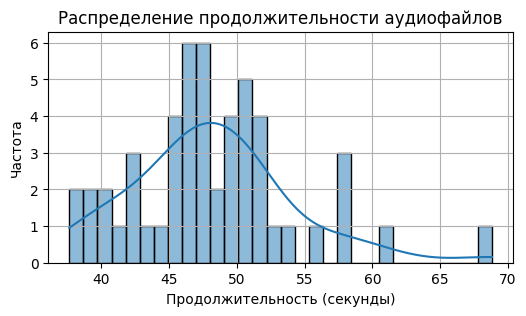

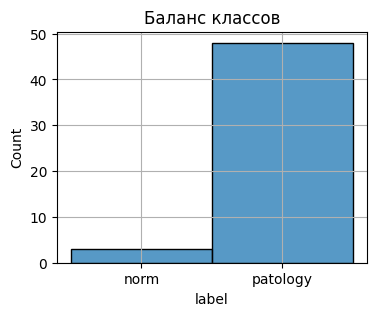

In [30]:
audio_paths = find_wav_files(norm_dir)
norm = len(audio_paths)
audio_paths.extend(find_wav_files(patology_dir))
patology = len(audio_paths) - norm

data = {
    "file_name": [],
    "duration": [],
    "sample_rate": [],
    # средние значения и стандартные отклонения мел-кепстральных коэффициентов
    "mfcc_mean": [],
    "mfcc_std": [],
    # средние значения и стандартные отклонения спектрального центроида
    "cent_mean": [],
    "cent_std": [],
    # средние значения и стандартные отклонения спектрального спада
    "rolloff_mean": [],
    "rolloff_std": [],
    # средние значения и стандартные отклонения cкорости пересечения нуля
    "zrate_mean": [],
    "zrate_std": [],
    "label": ["norm"] * norm + ["patology"] * patology,
    "label_num": [1]* norm + [0] * patology,
}

for file in tqdm(audio_paths):

    signal, sr = librosa.load(file, sr=None)  # sr=None сохраняет оригинальную частоту дискретизации

    duration = librosa.get_duration(y=signal, sr=sr)

    data["file_name"].append(file.split("/")[-1])
    data["duration"].append(duration)
    data["sample_rate"].append(sr)
    data["mfcc_mean"].append(np.mean(librosa.feature.mfcc(y=signal, sr=sr), axis=1))
    data["mfcc_std"].append(np.std(librosa.feature.mfcc(y=signal, sr=sr), axis=1))

    cent = librosa.feature.spectral_centroid(y=signal, sr=sr)
    data["cent_mean"].append(np.mean(cent))
    data["cent_std"].append(np.std(cent))

    rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr)
    data["rolloff_mean"].append(np.mean(rolloff))
    data["rolloff_std"].append(np.std(rolloff))

    zrate = librosa.feature.zero_crossing_rate(y=signal)
    data["zrate_mean"].append(np.mean(zrate))
    data["zrate_std"].append(np.std(zrate))
    
df = pd.DataFrame(data)

print("Основные статистики:")
print(df.describe())

# Распределение продолжительности аудио
plt.figure(figsize=(6, 3))
sns.histplot(df["duration"], bins=30, kde=True)
plt.title("Распределение продолжительности аудиофайлов")
plt.xlabel("Продолжительность (секунды)")
plt.ylabel("Частота")
plt.grid()
plt.show()

# Баланс классов
plt.figure(figsize=(4, 3))
sns.histplot(df["label"], bins=10)
plt.title("Баланс классов")
plt.grid()
plt.show()

In [8]:
signal, sr = librosa.load('../data/sample_norm.wav', sr=None)
print(sr)

22050


1


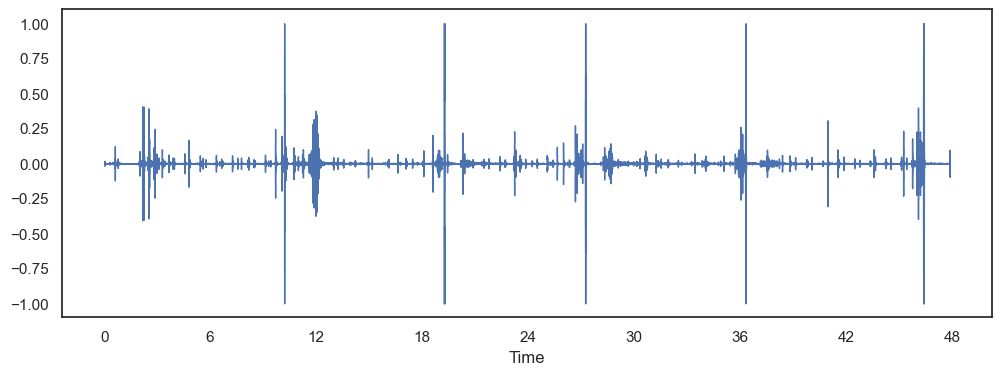

In [59]:
signal, sr = librosa.load('../data/sample_norm.wav', sr=None)
plt.figure(figsize=(12,4))
ld.waveshow(signal, sr=sr)
display(IPython.display.Audio(signal, rate = sr))
print(signal.ndim)

1 22050


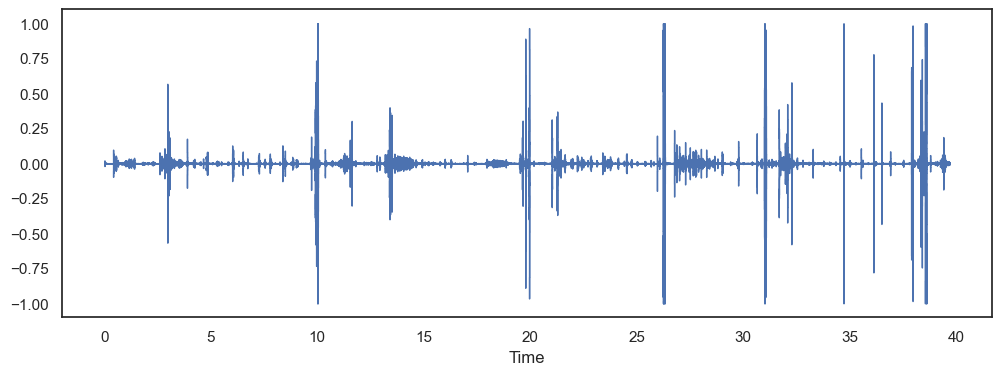

In [67]:
signal, sr = librosa.load('../data/sample_patology.wav', sr=None)
plt.figure(figsize=(12,4))
ld.waveshow(signal, sr=sr)
display(IPython.display.Audio(signal, rate = sr))
print(signal.ndim, sr)

In [ ]:
def preprocess_audio(audio_file_path):
	audio, sr = librosa.load(audio_file_path)
	mfcc_mean = np.mean(librosa.feature.mfcc(y=audio, sr=sr),   axis=1)
	return abs(mfcc_mean)

<Axes: >

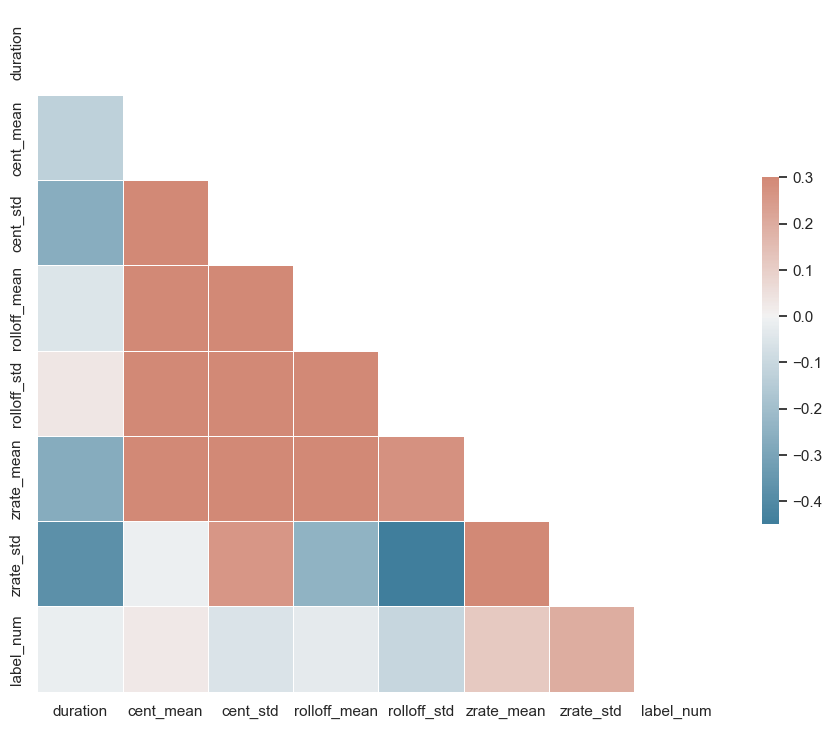

In [32]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

corr = df[['duration', 'cent_mean', 'cent_std', 'rolloff_mean', 'rolloff_std', 'zrate_mean', 'zrate_std', 'label_num']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Среди усредненных по аудио значений сильной корреляции с искомым значением нет, поэтому будет использовать для классификации как и принято, значения всего аудио

## CDPD Dataset

In [4]:
cdpd_info = pd.read_csv('../data/CDPD/training_data.csv') # , sep='\t', header=None

In [55]:
print(len(cdpd_info))
cdpd_info

942


Patient ID    Locations    Age     Sex  Height  Weight  Pregnancy status  \
0          2530  AV+PV+TV+MV  Child  Female    98.0    15.9             False   
1          9979  AV+PV+TV+MV  Child  Female   103.0    13.1             False   
2          9983  AV+PV+TV+MV  Child    Male   115.0    19.1             False   
3         13918  AV+PV+TV+MV  Child    Male    98.0    15.9             False   
4         14241  AV+PV+TV+MV  Child    Male    87.0    11.2             False   
..          ...          ...    ...     ...     ...     ...               ...   
937       85340  AV+PV+TV+MV  Child    Male   105.0    16.6             False   
938       85341  AV+PV+TV+MV  Child    Male    92.0    15.2             False   
939       85343  AV+PV+TV+MV  Child  Female    97.0    13.5             False   
940       85345        AV+PV  Child  Female   132.0    38.1             False   
941       85349     AV+PV+TV    NaN  Female     NaN     NaN              True   

      Murmur Murmur locations Most audible location  ...  \
0     Absent              NaN                   NaN  ...   
1    Present      AV+MV+PV+TV                    TV  ...   
2    Unknown              NaN                   NaN  ...   
3    Present               TV                    TV  ...   
4    Present      AV+MV+PV+TV                    PV  ...   
..       ...              ...                   ...  ...   
937   Absent              NaN                   NaN  ...   
938   Absent              NaN                   NaN  ...   
939  Present            MV+TV                    TV  ...   
940   Absent              NaN                   NaN  ...   
941   Absent              NaN                   NaN  ...   

    Systolic murmur grading Systolic murmur pitch Systolic murmur quality  \
0                       NaN                   NaN                     NaN   
1                    III/VI                  High                   Harsh   
2                       NaN                   NaN                     NaN   
3                      I/VI                   Low                 Blowing   
4                     II/VI                   Low                   Harsh   
..                      ...                   ...                     ...   
937                     NaN                   NaN                     NaN   
938                     NaN                   NaN                     NaN   
939                    I/VI                   Low                 Blowing   
940                     NaN                   NaN                     NaN   
941                     NaN                   NaN                     NaN   

    Diastolic murmur timing Diastolic murmur shape Diastolic murmur grading  \
0                       NaN                    NaN                      NaN   
1                       NaN                    NaN                      NaN   
2                       NaN                    NaN                      NaN   
3                       NaN                    NaN                      NaN   
4                       NaN                    NaN                      NaN   
..                      ...                    ...                      ...   
937                     NaN                    NaN                      NaN   
938                     NaN                    NaN                      NaN   
939                     NaN                    NaN                      NaN   
940                     NaN                    NaN                      NaN   
941                     NaN                    NaN                      NaN   

    Diastolic murmur pitch Diastolic murmur quality Campaign Additional ID  
0                      NaN                      NaN   CC2015           NaN  
1                      NaN                      NaN   CC2015           NaN  
2                      NaN                      NaN   CC2015           NaN  
3                      NaN                      NaN   CC2015           NaN  
4                      NaN                      NaN 

In [5]:
cdpd_info['Murmur'].unique()

array(['Absent', 'Present', 'Unknown'], dtype=object)

In [54]:
cdpd_info[cdpd_info['Murmur']=='Absent']

Patient ID    Locations    Age     Sex  Height  Weight  Pregnancy status  \
0          2530  AV+PV+TV+MV  Child  Female    98.0   15.90             False   
5         14998  AV+PV+TV+MV  Child    Male     NaN     NaN             False   
6         23625  AV+PV+TV+MV  Child  Female    92.0   14.00             False   
7         24160  AV+PV+TV+MV  Child  Female    98.0   17.66             False   
10        31737  AV+PV+TV+MV  Child  Female    90.0   14.40             False   
..          ...          ...    ...     ...     ...     ...               ...   
935       85338  AV+PV+TV+MV    NaN  Female     NaN     NaN              True   
937       85340  AV+PV+TV+MV  Child    Male   105.0   16.60             False   
938       85341  AV+PV+TV+MV  Child    Male    92.0   15.20             False   
940       85345        AV+PV  Child  Female   132.0   38.10             False   
941       85349     AV+PV+TV    NaN  Female     NaN     NaN              True   

     Murmur Murmur locations Most audible location  ...  \
0    Absent              NaN                   NaN  ...   
5    Absent              NaN                   NaN  ...   
6    Absent              NaN                   NaN  ...   
7    Absent              NaN                   NaN  ...   
10   Absent              NaN                   NaN  ...   
..      ...              ...                   ...  ...   
935  Absent              NaN                   NaN  ...   
937  Absent              NaN                   NaN  ...   
938  Absent              NaN                   NaN  ...   
940  Absent              NaN                   NaN  ...   
941  Absent              NaN                   NaN  ...   

    Systolic murmur grading Systolic murmur pitch Systolic murmur quality  \
0                       NaN                   NaN                     NaN   
5                       NaN                   NaN                     NaN   
6                       NaN                   NaN                     NaN   
7                       NaN                   NaN                     NaN   
10                      NaN                   NaN                     NaN   
..                      ...                   ...                     ...   
935                     NaN                   NaN                     NaN   
937                     NaN                   NaN                     NaN   
938                     NaN                   NaN                     NaN   
940                     NaN                   NaN                     NaN   
941                     NaN                   NaN                     NaN   

    Diastolic murmur timing Diastolic murmur shape Diastolic murmur grading  \
0                       NaN                    NaN                      NaN   
5                       NaN                    NaN                      NaN   
6                       NaN                    NaN                      NaN   
7                       NaN                    NaN                      NaN   
10                      NaN                    NaN                      NaN   
..                      ...                    ...                      ...   
935                     NaN                    NaN                      NaN   
937                     NaN                    NaN                      NaN   
938                     NaN                    NaN                      NaN   
940                     NaN                    NaN                      NaN   
941                     NaN                    NaN                      NaN   

    Diastolic murmur pitch Diastolic murmur quality Campaign Additional ID  
0                      NaN                      NaN   CC2015           NaN  
5                      NaN                      NaN   CC2015           NaN  
6                      NaN                      NaN   CC2015       50379.0  
7                      NaN                      NaN   CC2015           NaN  
10                     NaN                      NaN   CC2015    

In [34]:
cdpd_info[cdpd_info['Patient ID']==40058].dropna(axis=1)


Patient ID    Locations    Age     Sex  Height  Weight  Pregnancy status  \
17       40058  AV+PV+TV+MV  Child  Female   125.0    23.0             False   

    Murmur Campaign  
17  Absent   CC2015

In [36]:
cdpd_info[~cdpd_info['Most audible location'].isna()]

Patient ID    Locations     Age     Sex  Height  Weight  \
1          9979  AV+PV+TV+MV   Child  Female   103.0    13.1   
3         13918  AV+PV+TV+MV   Child    Male    98.0    15.9   
4         14241  AV+PV+TV+MV   Child    Male    87.0    11.2   
8         29045  AV+PV+TV+MV   Child  Female    88.0    12.5   
11        33151  AV+PV+TV+MV   Child  Female   141.0    30.9   
..          ...          ...     ...     ...     ...     ...   
896       85269        AV+PV  Infant  Female    62.0     6.2   
898       85276           MV  Infant  Female    46.0     3.9   
914       85306        AV+MV   Child  Female    77.0     8.9   
936       85339           MV  Infant  Female     NaN     NaN   
939       85343  AV+PV+TV+MV   Child  Female    97.0    13.5   

     Pregnancy status   Murmur Murmur locations Most audible location  ...  \
1               False  Present      AV+MV+PV+TV                    TV  ...   
3               False  Present               TV                    TV  ...   
4               False  Present      AV+MV+PV+TV                    PV  ...   
8               False  Present      AV+MV+PV+TV                    TV  ...   
11              False  Present            MV+TV                    TV  ...   
..                ...      ...              ...                   ...  ...   
896             False  Present               PV                    PV  ...   
898             False  Present               MV                    MV  ...   
914             False  Present            AV+MV                    AV  ...   
936             False  Present               MV                    MV  ...   
939             False  Present            MV+TV                    TV  ...   

    Systolic murmur grading Systolic murmur pitch Systolic murmur quality  \
1                    III/VI                  High                   Harsh   
3                      I/VI                   Low                 Blowing   
4                     II/VI                   Low                   Harsh   
8                     II/VI                   Low                 Blowing   
11                     I/VI                   Low                   Harsh   
..                      ...                   ...                     ...   
896                    I/VI                   Low                 Blowing   
898                    I/VI                   Low                 Blowing   
914                    I/VI                   Low                 Blowing   
936                    I/VI                   Low                 Blowing   
939                    I/VI                   Low                 Blowing   

    Diastolic murmur timing Diastolic murmur shape Diastolic murmur grading  \
1                       NaN                    NaN                      NaN   
3                       NaN                    NaN                      NaN   
4                       NaN                    NaN                      NaN   
8                       NaN                    NaN                      NaN   
11                      NaN                    NaN                      NaN   
..                      ...                    ...                      ...   
896                     NaN                    NaN                      NaN   
898                     NaN                    NaN                      NaN   
914                     NaN                    NaN                      NaN   
936                     NaN                    NaN                      NaN   
939                     NaN                    NaN                      NaN   

    Diastolic murmur pitch Diastolic murmur quality Campaign Additional ID  
1                      NaN                      NaN   CC2015           NaN  
3                      NaN                      NaN   CC2015           NaN  
4                      NaN                      NaN   CC2015           NaN  
8                      NaN                      NaN   CC2015           NaN  
11                     NaN              

In [39]:
cdpd_info['Locations'].unique()

array(['AV+PV+TV+MV', 'AV+MV', 'PV+TV+MV', 'AV', 'MV', 'AV+PV+MV',
       'PV+MV', 'AV+AV+PV+PV+TV+MV', 'AV+PV+TV', 'AV+PV+TV+MV+MV', 'PV',
       'PV+TV+TV', 'AV+PV+PV+TV+TV+MV', 'PV+TV', 'AV+MV+MV',
       'AV+PV+MV+Phc+Phc', 'AV+PV', 'TV', 'AV+AV+MV', 'AV+PV+TV+TV+MV',
       'AV+AV+MV+MV', 'AV+AV+PV+TV+MV', 'AV+TV+MV', 'AV+PV+TV+MV+Phc',
       'AV+AV+AV+MV', 'AV+AV+PV+TV+MV+MV', 'TV+MV', 'TV+MV+Phc'],
      dtype=object)

In [40]:
cdpd_info[cdpd_info['Locations'].isin(['AV+PV+TV+MV', 'AV+PV+MV', 'AV+AV+PV+PV+TV+MV', 'AV+MV+MV', 
                                        'AV+PV+MV+Phc+Phc', 'AV+PV+TV+TV+MV', 'AV+AV+MV+MV', 'AV+AV+PV+TV+MV', 'AV+PV+TV+MV+Phc', 'AV+AV+AV+MV', 'AV+AV+PV+TV+MV+MV', ])]

Patient ID    Locations    Age     Sex  Height  Weight  Pregnancy status  \
0          2530  AV+PV+TV+MV  Child  Female    98.0    15.9             False   
1          9979  AV+PV+TV+MV  Child  Female   103.0    13.1             False   
2          9983  AV+PV+TV+MV  Child    Male   115.0    19.1             False   
3         13918  AV+PV+TV+MV  Child    Male    98.0    15.9             False   
4         14241  AV+PV+TV+MV  Child    Male    87.0    11.2             False   
..          ...          ...    ...     ...     ...     ...               ...   
934       85337  AV+PV+TV+MV  Child    Male   130.0    27.3             False   
935       85338  AV+PV+TV+MV    NaN  Female     NaN     NaN              True   
937       85340  AV+PV+TV+MV  Child    Male   105.0    16.6             False   
938       85341  AV+PV+TV+MV  Child    Male    92.0    15.2             False   
939       85343  AV+PV+TV+MV  Child  Female    97.0    13.5             False   

      Murmur Murmur locations Most audible location  ...  \
0     Absent              NaN                   NaN  ...   
1    Present      AV+MV+PV+TV                    TV  ...   
2    Unknown              NaN                   NaN  ...   
3    Present               TV                    TV  ...   
4    Present      AV+MV+PV+TV                    PV  ...   
..       ...              ...                   ...  ...   
934   Absent              NaN                   NaN  ...   
935   Absent              NaN                   NaN  ...   
937   Absent              NaN                   NaN  ...   
938   Absent              NaN                   NaN  ...   
939  Present            MV+TV                    TV  ...   

    Systolic murmur grading Systolic murmur pitch Systolic murmur quality  \
0                       NaN                   NaN                     NaN   
1                    III/VI                  High                   Harsh   
2                       NaN                   NaN                     NaN   
3                      I/VI                   Low                 Blowing   
4                     II/VI                   Low                   Harsh   
..                      ...                   ...                     ...   
934                     NaN                   NaN                     NaN   
935                     NaN                   NaN                     NaN   
937                     NaN                   NaN                     NaN   
938                     NaN                   NaN                     NaN   
939                    I/VI                   Low                 Blowing   

    Diastolic murmur timing Diastolic murmur shape Diastolic murmur grading  \
0                       NaN                    NaN                      NaN   
1                       NaN                    NaN                      NaN   
2                       NaN                    NaN                      NaN   
3                       NaN                    NaN                      NaN   
4                       NaN                    NaN                      NaN   
..                      ...                    ...                      ...   
934                     NaN                    NaN                      NaN   
935                     NaN                    NaN                      NaN   
937                     NaN                    NaN                      NaN   
938                     NaN                    NaN                      NaN   
939                     NaN                    NaN                      NaN   

    Diastolic murmur pitch Diastolic murmur quality Campaign Additional ID  
0                      NaN                      NaN   CC2015           NaN  
1                      NaN                      NaN   CC2015           NaN  
2                      NaN                      NaN   CC2015           NaN  
3                      NaN                      NaN   CC2015           NaN  
4                      NaN                      NaN 

In [42]:
cdpd_info[cdpd_info['Locations'].isin(['AV+PV+TV+MV', 'AV+PV+MV', 'AV+AV+PV+PV+TV+MV', 'AV+MV+MV', 
                                        'AV+PV+MV+Phc+Phc', 'AV+PV+TV+TV+MV', 'AV+AV+MV+MV', 'AV+AV+PV+TV+MV', 'AV+PV+TV+MV+Phc', 'AV+AV+AV+MV', 'AV+AV+PV+TV+MV+MV', ])&(cdpd_info['Murmur']=='Unknown')]

Patient ID    Locations         Age     Sex  Height  Weight  \
2          9983  AV+PV+TV+MV       Child    Male   115.0   19.10   
46        49638     AV+PV+MV      Infant    Male    78.0   12.50   
165       50116  AV+PV+TV+MV       Child    Male   126.0   20.60   
426       68175  AV+PV+TV+MV       Child    Male   105.0   18.10   
447       68347  AV+PV+TV+MV      Infant  Female    69.0    7.69   
508       68796  AV+PV+TV+MV       Child  Female   138.0   33.50   
510       68831  AV+PV+TV+MV  Adolescent  Female    58.0   51.60   
524       69060  AV+PV+TV+MV       Child    Male    87.0   12.50   
526       69067  AV+PV+TV+MV       Child  Female   121.0   25.60   
618       84765  AV+PV+TV+MV       Child    Male   131.0   34.20   
685       84892     AV+PV+MV       Child  Female   153.0   37.60   
734       84988     AV+PV+MV      Infant  Female    70.0    8.00   
850       85182  AV+PV+TV+MV       Child    Male   133.0   42.60   
854       85196  AV+PV+TV+MV       Child  Female   129.0   28.80   
871       85227  AV+PV+TV+MV       Child    Male    90.0   14.60   
921       85319  AV+PV+TV+MV       Child  Female   138.0   39.80   

     Pregnancy status   Murmur Murmur locations Most audible location  ...  \
2               False  Unknown              NaN                   NaN  ...   
46              False  Unknown              NaN                   NaN  ...   
165             False  Unknown              NaN                   NaN  ...   
426             False  Unknown              NaN                   NaN  ...   
447             False  Unknown              NaN                   NaN  ...   
508             False  Unknown              NaN                   NaN  ...   
510             False  Unknown              NaN                   NaN  ...   
524             False  Unknown              NaN                   NaN  ...   
526             False  Unknown              NaN                   NaN  ...   
618             False  Unknown              NaN                   NaN  ...   
685             False  Unknown              NaN                   NaN  ...   
734             False  Unknown              NaN                   NaN  ...   
850             False  Unknown              NaN                   NaN  ...   
854             False  Unknown              NaN                   NaN  ...   
871             False  Unknown              NaN                   NaN  ...   
921             False  Unknown              NaN                   NaN  ...   

    Systolic murmur grading Systolic murmur pitch Systolic murmur quality  \
2                       NaN                   NaN                     NaN   
46                      NaN                   NaN                     NaN   
165                     NaN                   NaN                     NaN   
426                     NaN                   NaN                     NaN   
447                     NaN                   NaN                     NaN   
508                     NaN                   NaN                     NaN   
510                     NaN                   NaN                     NaN   
524                     NaN                   NaN                     NaN   
526                     NaN                   NaN                     NaN   
618                     NaN                   NaN                     NaN   
685                     NaN                   NaN                     NaN   
734                     NaN                   NaN                     NaN   
850                     NaN                   NaN                     NaN   
854                     NaN                   NaN                     NaN   
871                     NaN                   NaN                     NaN   
921                     NaN                   NaN                     NaN   

    Diastolic murmur timing Diastolic murmur shape Diastolic murmur grading  \
2                       NaN                    NaN                      NaN   
46                      NaN                    NaN   

In [43]:
cdpd_info[cdpd_info['Locations'].isin(['AV+PV+TV+MV', 'AV+PV+MV', 'AV+AV+PV+PV+TV+MV', 'AV+MV+MV', 
                                        'AV+PV+MV+Phc+Phc', 'AV+PV+TV+TV+MV', 'AV+AV+MV+MV', 'AV+AV+PV+TV+MV', 'AV+PV+TV+MV+Phc', 'AV+AV+AV+MV', 'AV+AV+PV+TV+MV+MV', ])&(cdpd_info['Murmur']=='Present')]

Patient ID    Locations         Age     Sex  Height  Weight  \
1          9979  AV+PV+TV+MV       Child  Female   103.0    13.1   
3         13918  AV+PV+TV+MV       Child    Male    98.0    15.9   
4         14241  AV+PV+TV+MV       Child    Male    87.0    11.2   
8         29045  AV+PV+TV+MV       Child  Female    88.0    12.5   
11        33151  AV+PV+TV+MV       Child  Female   141.0    30.9   
..          ...          ...         ...     ...     ...     ...   
856       85198  AV+PV+TV+MV      Infant  Female    84.0    10.9   
860       85207  AV+PV+TV+MV  Adolescent    Male   153.0    53.9   
867       85219  AV+PV+TV+MV         NaN    Male   102.0    16.0   
892       85261  AV+PV+TV+MV       Child  Female   117.0    20.8   
939       85343  AV+PV+TV+MV       Child  Female    97.0    13.5   

     Pregnancy status   Murmur Murmur locations Most audible location  ...  \
1               False  Present      AV+MV+PV+TV                    TV  ...   
3               False  Present               TV                    TV  ...   
4               False  Present      AV+MV+PV+TV                    PV  ...   
8               False  Present      AV+MV+PV+TV                    TV  ...   
11              False  Present            MV+TV                    TV  ...   
..                ...      ...              ...                   ...  ...   
856             False  Present      AV+MV+PV+TV                    AV  ...   
860             False  Present      AV+MV+PV+TV                    TV  ...   
867             False  Present         MV+PV+TV                    PV  ...   
892             False  Present      AV+MV+PV+TV                    TV  ...   
939             False  Present            MV+TV                    TV  ...   

    Systolic murmur grading Systolic murmur pitch Systolic murmur quality  \
1                    III/VI                  High                   Harsh   
3                      I/VI                   Low                 Blowing   
4                     II/VI                   Low                   Harsh   
8                     II/VI                   Low                 Blowing   
11                     I/VI                   Low                   Harsh   
..                      ...                   ...                     ...   
856                  III/VI                  High                   Harsh   
860                  III/VI                  High                   Harsh   
867                    I/VI                   Low                   Harsh   
892                  III/VI                  High                   Harsh   
939                    I/VI                   Low                 Blowing   

    Diastolic murmur timing Diastolic murmur shape Diastolic murmur grading  \
1                       NaN                    NaN                      NaN   
3                       NaN                    NaN                      NaN   
4                       NaN                    NaN                      NaN   
8                       NaN                    NaN                      NaN   
11                      NaN                    NaN                      NaN   
..                      ...                    ...                      ...   
856                     NaN                    NaN                      NaN   
860                     NaN                    NaN                      NaN   
867                     NaN                    NaN                      NaN   
892                     NaN                    NaN                      NaN   
939                     NaN                    NaN                      NaN   

    Diastolic murmur pitch Diastolic murmur quality Campaign Additional ID  
1                      NaN                      NaN   CC2015           NaN  
3                      NaN                      NaN   CC2015           NaN  
4                      NaN                      NaN   CC2015           NaN  
8                      NaN                      NaN   CC2015         

In [41]:
cdpd_info[cdpd_info['Locations'].isin(['AV+PV+TV+MV', 'AV+PV+MV', 'AV+AV+PV+PV+TV+MV', 'AV+MV+MV', 
                                        'AV+PV+MV+Phc+Phc', 'AV+PV+TV+TV+MV', 'AV+AV+MV+MV', 'AV+AV+PV+TV+MV', 'AV+PV+TV+MV+Phc', 'AV+AV+AV+MV', 'AV+AV+PV+TV+MV+MV', ])&(cdpd_info['Murmur']=='Absent')]

Patient ID    Locations    Age     Sex  Height  Weight  Pregnancy status  \
0          2530  AV+PV+TV+MV  Child  Female    98.0   15.90             False   
5         14998  AV+PV+TV+MV  Child    Male     NaN     NaN             False   
6         23625  AV+PV+TV+MV  Child  Female    92.0   14.00             False   
7         24160  AV+PV+TV+MV  Child  Female    98.0   17.66             False   
10        31737  AV+PV+TV+MV  Child  Female    90.0   14.40             False   
..          ...          ...    ...     ...     ...     ...               ...   
931       85334  AV+PV+TV+MV  Child  Female   106.0   20.50             False   
934       85337  AV+PV+TV+MV  Child    Male   130.0   27.30             False   
935       85338  AV+PV+TV+MV    NaN  Female     NaN     NaN              True   
937       85340  AV+PV+TV+MV  Child    Male   105.0   16.60             False   
938       85341  AV+PV+TV+MV  Child    Male    92.0   15.20             False   

     Murmur Murmur locations Most audible location  ...  \
0    Absent              NaN                   NaN  ...   
5    Absent              NaN                   NaN  ...   
6    Absent              NaN                   NaN  ...   
7    Absent              NaN                   NaN  ...   
10   Absent              NaN                   NaN  ...   
..      ...              ...                   ...  ...   
931  Absent              NaN                   NaN  ...   
934  Absent              NaN                   NaN  ...   
935  Absent              NaN                   NaN  ...   
937  Absent              NaN                   NaN  ...   
938  Absent              NaN                   NaN  ...   

    Systolic murmur grading Systolic murmur pitch Systolic murmur quality  \
0                       NaN                   NaN                     NaN   
5                       NaN                   NaN                     NaN   
6                       NaN                   NaN                     NaN   
7                       NaN                   NaN                     NaN   
10                      NaN                   NaN                     NaN   
..                      ...                   ...                     ...   
931                     NaN                   NaN                     NaN   
934                     NaN                   NaN                     NaN   
935                     NaN                   NaN                     NaN   
937                     NaN                   NaN                     NaN   
938                     NaN                   NaN                     NaN   

    Diastolic murmur timing Diastolic murmur shape Diastolic murmur grading  \
0                       NaN                    NaN                      NaN   
5                       NaN                    NaN                      NaN   
6                       NaN                    NaN                      NaN   
7                       NaN                    NaN                      NaN   
10                      NaN                    NaN                      NaN   
..                      ...                    ...                      ...   
931                     NaN                    NaN                      NaN   
934                     NaN                    NaN                      NaN   
935                     NaN                    NaN                      NaN   
937                     NaN                    NaN                      NaN   
938                     NaN                    NaN                      NaN   

    Diastolic murmur pitch Diastolic murmur quality Campaign Additional ID  
0                      NaN                      NaN   CC2015           NaN  
5                      NaN                      NaN   CC2015           NaN  
6                      NaN                      NaN   CC2015       50379.0  
7                      NaN                      NaN   CC2015           NaN  
10                     NaN                      NaN   CC2015    

In [ ]:
# патология - 

In [17]:
# с шумом без патологий ищем
cdpd_info[(cdpd_info['Murmur']=='Present')&(cdpd_info['Systolic murmur pitch'].isna())]

Patient ID    Locations    Age   Sex  Height  Weight  Pregnancy status  \
807       85119  AV+PV+TV+MV  Child  Male   161.0    43.7             False   

      Murmur Murmur locations Most audible location  ...  \
807  Present            AV+PV                    PV  ...   

    Systolic murmur grading Systolic murmur pitch Systolic murmur quality  \
807                     NaN                   NaN                     NaN   

    Diastolic murmur timing Diastolic murmur shape Diastolic murmur grading  \
807         Early-diastolic            Decrescendo                     I/IV   

    Diastolic murmur pitch Diastolic murmur quality Campaign Additional ID  
807                    Low                  Blowing   CC2015           NaN  

[1 rows x 22 columns]

In [21]:
print(cdpd_info.columns)


Index(['Patient ID', 'Locations', 'Age', 'Sex', 'Height', 'Weight',
       'Pregnancy status', 'Murmur', 'Murmur locations',
       'Most audible location', 'Systolic murmur timing',
       'Systolic murmur shape', 'Systolic murmur grading',
       'Systolic murmur pitch', 'Systolic murmur quality',
       'Diastolic murmur timing', 'Diastolic murmur shape',
       'Diastolic murmur grading', 'Diastolic murmur pitch',
       'Diastolic murmur quality', 'Campaign', 'Additional ID'],
      dtype='object')


In [25]:
cdpd_info.head(50).to_excel('cdpd_sample.xlsx')

In [ ]:
# утром надо добавить полную версию спектограмм человеков и указать где какие клапаны были
зато только для этого датасета так

In [7]:
# с шумом патологией
signal, sr = librosa.load('../data/CDPD/training_data/9979_TV.wav', sr=None)
print(sr)

4000


1 4000


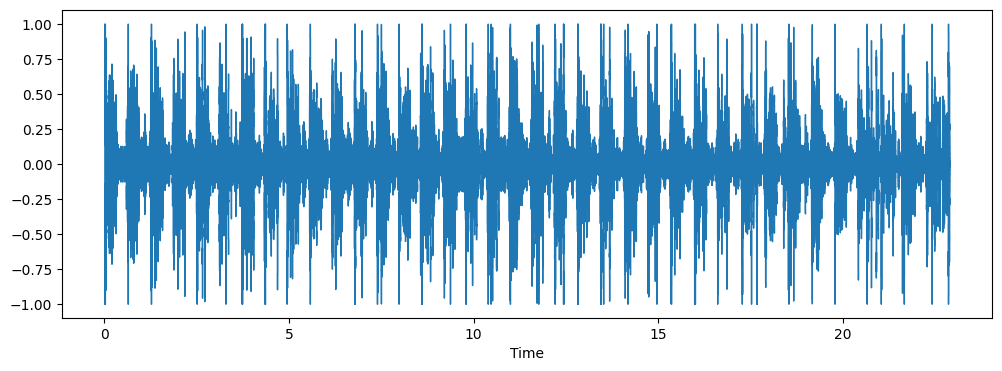

In [14]:
# с шумом патологией
signal, sr = librosa.load('../data/CDPD/training_data/9979_TV.wav', sr=None)
plt.figure(figsize=(12,4))
ld.waveshow(signal, sr=sr)
display(IPython.display.Audio(signal, rate = sr))
print(signal.ndim, sr)

In [ ]:
# с шумом но без патологий
signal, sr = librosa.load('../data/CDPD/training_data/.wav', sr=None)
plt.figure(figsize=(12,4))
ld.waveshow(signal, sr=sr)
display(IPython.display.Audio(signal, rate = sr))
print(signal.ndim, sr)

1 4000


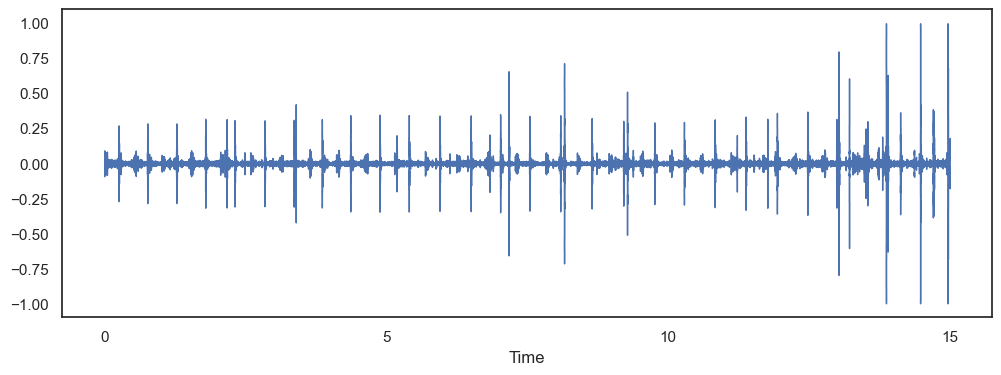

In [69]:
# без шума без патологий
signal, sr = librosa.load('../data/CDPD/training_data/2530_TV.wav', sr=None)
plt.figure(figsize=(12,4))
ld.waveshow(signal, sr=sr)
display(IPython.display.Audio(signal, rate = sr))
print(signal.ndim, sr)

## CHSR Dataset

In [26]:
chsr_info = pd.read_csv('../data/CHSR/training-b/REFERENCE.csv')
# -1 - normal, 1 - Abnormal, 0 - Uncertain

In [58]:
chsr_info


b0001  -1
0    b0002  -1
1    b0003  -1
2    b0004  -1
3    b0005  -1
4    b0006  -1
..     ...  ..
484  b0486  -1
485  b0487  -1
486  b0488  -1
487  b0489  -1
488  b0490  -1

[489 rows x 2 columns]

In [27]:
chsr_info[chsr_info['-1']!=-1]

b0001  -1
6    b0008   1
11   b0013   1
14   b0016   1
16   b0018   1
20   b0022   1
..     ...  ..
466  b0468   1
469  b0471   1
472  b0474   1
474  b0476   1
482  b0484   1

[104 rows x 2 columns]

1 2000


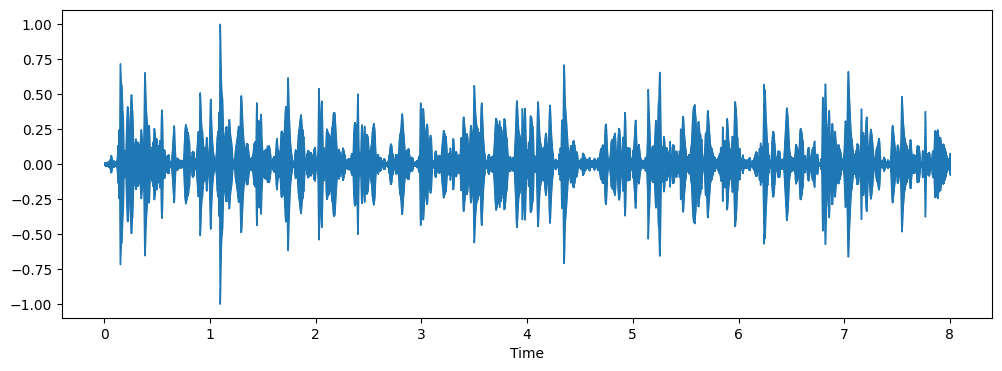

In [28]:
# -1
signal1, sr = librosa.load('../data/CHSR/training-b/b0487.wav', sr=None)
plt.figure(figsize=(12,4))
ld.waveshow(signal1, sr=sr)
display(IPython.display.Audio(signal1, rate = sr))
print(signal1.ndim, sr)

1 2000


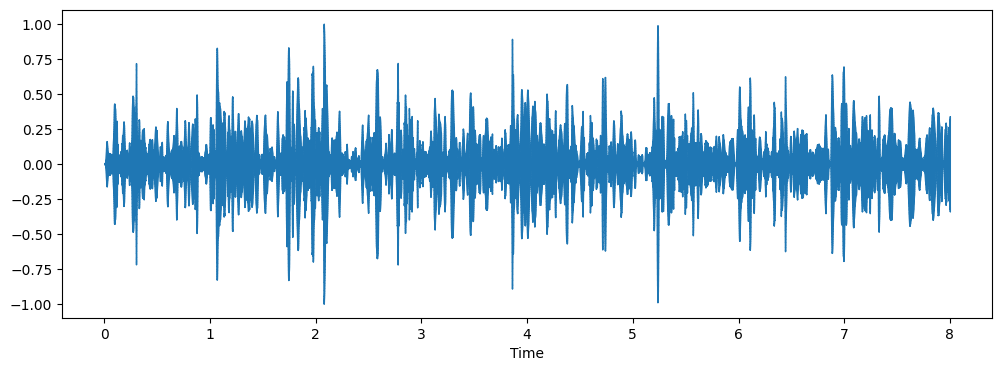

In [29]:
# 1
signal1, sr = librosa.load('../data/CHSR/training-b/b0008.wav', sr=None)
plt.figure(figsize=(12,4))
ld.waveshow(signal1, sr=sr)
display(IPython.display.Audio(signal1, rate = sr))
print(signal1.ndim, sr)

1 2000


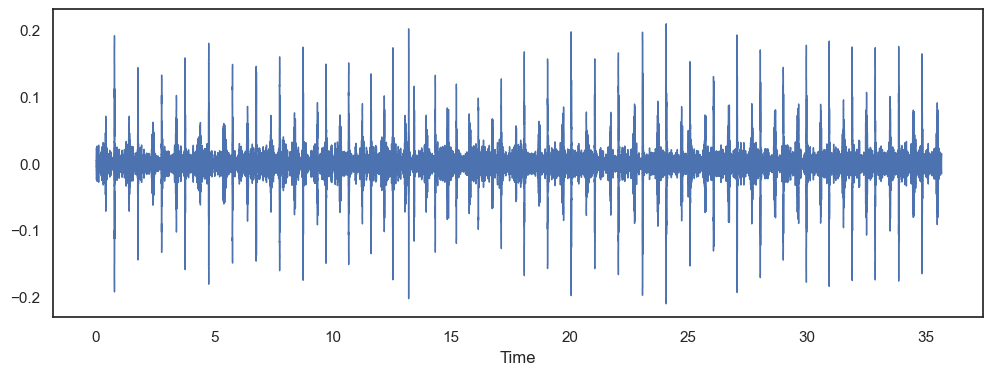

In [68]:
signal1, sr = librosa.load('../data/CHSR/training-a/a0001.wav', sr=None)
plt.figure(figsize=(12,4))
ld.waveshow(signal1, sr=sr)
display(IPython.display.Audio(signal1, rate = sr))
print(signal1.ndim, sr)